### 3.6.2.3 Transformer

与 RNN（Vallina、LSTM、GRU）和 基于 RNN 的 seq2seq 等递归神经网络不同，Vaswani, A.等人<sup>[Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., … Polosukhin, I. (2017). Attention Is All You Need. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1706.03762]</sup> 2017年提出了 transformer 网络，并已证明在序列到序列（sequence-to-sequence）任务中具有更好的表现，且拥有更高的并行性。transformer 并不使用 RNN 网络，以注意力机制为主要思想构建网络，这包括响应解码对编码各个词汇（token）的注意力（参数`queries`向量来自于解码状态；参数`keys`和`values`向量来自编码状态），即`encoder-decoder attention`（编码-解码 注意力）；也包括解码器输入语句自身各个词汇对其它词汇的注意力，以更好的理解和表示序列，即`self-attention`（自注意力），例如对于文本`The animal didn't cross the street because it was too tired`，词汇`it`代指其它词汇`animal`，而不是`street`等。transformer 的网络结构如下图<sup>[The Illustrated Transformer, <https://jalammar.github.io/illustrated-transformer/>]</sup>，同样包括编码器和解码器，编码器中引入`self-attention`，解码器中对应编码器引入`encoer-decoder attention`，以及为了表述文本词语顺序的`position encoding`层，改善收敛稳定性和提高训练质量的`add & normalize`层，及处理注意力机制等新增信息的前馈神经网络层`feed forward（FFN）`等。同时，transformer 有多个编码器和解码器堆叠，而`self-attention`重复计算多次，获得多个`z`矩阵后并压缩为1个，称为`multi-headed`。


<img src="../imgs/3_6/3_6_16.png" height='auto' width='auto' title="caDesign"> 

#### 1）位置编码 —— Positional encoding

由于 transformer 网络不含递归和卷积，为了使模型利用序列顺序信息，需要注入一些关于序列中词汇的相对或绝对位置信息。因此，在编码器和解码器输入端对词嵌入添加了“位置编码”（positional encodings）。位置编码与嵌入具有相同的维数，因此可以对两者求和。位置编码可以通过学习习得，也可以用固定的形似，例如使用不同频率的正弦和余弦函数，公式为，$P E_{(p o s, 2 i)}=\sin \left(p o s / 10000^{2 i / d_{\text {model }}}\right)$；$P E_{(p o s, 2 i+1)}=\cos \left(p o s / 10000^{2 i / d_{\text {model }}}\right)$，式中，$pos$是位置，$i$是维数，即位置编码的每一个维度对应于一个正弦波。波长为从$2 \pi $到$10000   \bullet  2 \pi $的几何级数。transformer 作者解释使用正余弦函数是为了让模型可以很容易的通过相对位置来学习，因为对于任何固定的偏移$k$，$PE_{pos+k}$可以表示为$PE_{pos}$的线性函数。

对应代码为：

```python
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
```

#### 2）注意力（attention）—— self-attention

注意力函数（同时可以查看下图<sup>[Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., … Polosukhin, I. (2017). Attention Is All You Need. arXiv [Cs.CL]. Retrieved from http://arxiv.org/abs/1706.03762]</sup>）可以描述为将查询（queries）$q$和一组键值对（keys，values）$k,v$映射到输出$z$，其中查询、键、值和输出都是向量，查询和键的维度为$d_k$，值得维度为$d_v$。输出为值的加权和，且分配给每个值的权重由查询与相应键的兼容性（compatibility）函数计算。将自注意力（self-attention）称之为缩放的点积注意力（Scaled Dot-Product Attention），首先计算查询和键大的点积（dot products），然后除以$\sqrt{d_k}$，并应用 softmax 函数获得值的权重，公式为$\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V$。

<img src="../imgs/3_6/3_6_17.png" height='auto' width=500 title="caDesign"> 

transformer 作者发现与其使用$d_{model}$维度的键、值和查询的一组注意力函数，不如并行多组生成$d_v$维输出，并连接（ concatenate）起来再次映射得到最终值，称为多头注意力（Multi-head attention ）。多头注意力允许模型联合处理来自不同位置不同表示的子空间信息，公式可表述为$\operatorname{MultiHead}(Q, K, V)=\operatorname{Concat}\left(\operatorname{head}_1, \ldots, \operatorname{head}_{\mathrm{h}}\right) W^O, \text {where} ,  head_{\mathrm{i}}=\operatorname{Attention}\left(Q W_i^Q, K W_i^K, V W_i^V\right)$，其中映射的参数矩阵有$W_i^Q \in \mathbb{R}^{d_{\text {model }} \times d_k}, W_i^K \in \mathbb{R}^{d_{\text {model }} \times d_k}, W_i^V \in \mathbb{R}^{d_{\text {model }} \times d_v}$ ,$W^O \in \mathbb{R}^{h d_v \times d_{\text {model }}}$。



#### 3）层归一化（Layer normalization）—— add & normalize<sup>[Ba, J. L., Kiros, J. R., & Hinton, G. E. (2016). Layer Normalization. arXiv [Stat.ML]. Retrieved from http://arxiv.org/abs/1607.06450]</sup>

一层输出的变化往往会导致下一层累计输入发生高度相关的变化， 尤其对于输出变化很大的 ReLU 层，而“协变量位移”（covariate shift”）问题可以通过固定每一层中总和输入的均值和方差来减少，公式为$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$，式中，$ \gamma$和$ \beta$是可学习的仿射变化参数<sup>[LayerNorm_PyTorch, <https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html?highlight=layernorm#torch.nn.LayerNorm>]</sup>。`PyTorch`库将层归一化方法写入到了`torch.nn.LayerNorm`类中。

#### 4）前馈神经网络 —— feed forward

除了注意力层外，编码器和解码器的每一层都包含并行多个完全连接的前馈神经网络，对应连接注意力层的各个输出$z_n$。每个前馈网络有两个线性变化和一个 ReLU 层，公式为$\operatorname{FFN}(x)=\max \left(0, x W_1+b_1\right) W_2+b_2$。虽然线性变换在不同位置上是相同的，但它们在每一层之间使用不同的参数。

#### 5）残差连接（ Residual connections）

在 transformer 网络图解中可以观察到层间连接的虚线，即为残差连接（ Residual connections），为一种在深度神经网络中广泛应用的技术，旨在解决深度神经网络训练过程中的梯度消失和梯度爆炸等问题，例如信息从一层传递到下一层时存在的信息损失。

`PyTorch`将 transformer 的方法写入到了`torch.nn.TransformerEncoderLayer`中，并给出了[Language modeling with nn.transformer and torchtext](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#evaluate-the-best-model-on-the-test-dataset)示例文档。这里将该文档的方法迁移到`USDA`库，方便调用。

In [1]:
%load_ext autoreload 
%autoreload 2 

import usda.models as usda_models

from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
from torch import nn
import os
import time
import math

通过`PyTorch`的[torchtext.datasets](https://pytorch.org/text/stable/datasets.html)可以获得多种用于自然语言处理的文本数据集，示例中调入的为[WikiText2](https://pytorch.org/text/stable/datasets.html#wikitext-2)数据集。

In [2]:
train_iter=WikiText2(split='train')
tokenizer=get_tokenizer('basic_english')
vocab=build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

train_iter, val_iter, test_iter=WikiText2()
train_data=usda_models.data_process4transformer(train_iter,vocab,tokenizer)
val_data=usda_models.data_process4transformer(val_iter,vocab,tokenizer)
test_data=usda_models.data_process4transformer(test_iter,vocab,tokenizer) 

建立训练数据集。

In [3]:
batch_size=20
eval_batch_size=10
train_data=usda_models.batchify(train_data, batch_size)  
val_data=usda_models.batchify(val_data, eval_batch_size)
test_data=usda_models.batchify(test_data, eval_batch_size) 

print(f'train data:\n{train_data}\nshape={train_data.shape}')

train data:
tensor([[    9,    59,   564,  ..., 11652,  2435,     1],
        [ 3849,    12,   300,  ...,    47,    30,  1990],
        [ 3869,   315,    19,  ...,    97,  7720,     4],
        ...,
        [  587,  4011,    59,  ...,     1,  1439, 12313],
        [ 4987,    29,     4,  ...,  3165, 17106,  2060],
        [    6,     8,     1,  ...,    62,    18,     2]], device='cuda:0')
shape=torch.Size([102499, 20])


配置 transformer 模型参数，并初始化模型。

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ntokens=len(vocab)  # size of vocabulary
emsize=200  # embedding dimension
d_hid=200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers=2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead=2  # number of heads in ``nn.MultiheadAttention``
dropout=0.2  # dropout probability
model=usda_models.TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)    
print(model)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=200, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=200, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (embedding): Embedding(28782, 200)
  (linear): Linear(in_features=200, out_features=28782, bias=True)
)


配置损失和优化函数，及调整学习率。

In [70]:
criterion=nn.CrossEntropyLoss()
lr=5.0  # learning rate
optimizer=torch.optim.SGD(model.parameters(), lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)        
        
best_val_loss=float('inf')
epochs=2
bptt=35

save_path=r'I:\model_ckpts\transformer'
best_model_params_path=os.path.join(save_path, "transformer_model.pth")

训练模型和保存模型参数。

In [77]:
for epoch in range(1, epochs + 1):
    epoch_start_time=time.time()
    usda_models.train4transformer(model,criterion,optimizer,scheduler,train_data,ntokens,epoch,bptt)
    val_loss=usda_models.evaluate4transformer(model,criterion, ntokens, val_data)
    val_ppl=math.exp(val_loss)
    elapsed=time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_params_path)

    scheduler.step()

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 14.29 | loss  2.66 | ppl    14.35
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 14.31 | loss  2.77 | ppl    15.97
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 13.56 | loss  2.66 | ppl    14.23
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 14.54 | loss  2.58 | ppl    13.20
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 13.77 | loss  2.63 | ppl    13.94
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 13.65 | loss  2.56 | ppl    12.95
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 13.72 | loss  2.95 | ppl    19.12
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 14.50 | loss  2.67 | ppl    14.46
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 14.95 | loss  2.75 | ppl    15.64
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 14.84 | loss  2.64 | ppl    14.03
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 13.94 | loss  3.04 | ppl    20.91
| epoch   1 |  2400/ 

加载模型，并通过给定的提示词预测后续词。

In [140]:
model.load_state_dict(torch.load(best_model_params_path)) # load best model states  

prompt="the first in the Super Mario Land series , developed and published by Nintendo as a launch title for their Game Boy handheld game console . In gameplay similar to that of the 1985 Super Mario Bros. , but resized for the smaller device 's screen , the player advances Mario to the end of 12 levels by moving to the right and jumping across platforms to avoid enemies and pitfalls . Unlike other Mario games , Super Mario Land is set in Sarasaland , a new environment depicted in line art ,"
indexed_tokens=usda_models.data_process4transformer(tokenizer(prompt),vocab,tokenizer)
print(indexed_tokens)
indexed_tokens_batch=usda_models.batchify(indexed_tokens, bsz=10)
print(indexed_tokens_batch)

tensor([    1,    37,     6,     1,  1269,  2124,   352,    93,     2,   452,
            5,   326,    19,  3179,    14,     8,  2847,   363,    17,    36,
           67,  1361, 14407,    67,  5972,     3,     6,  2096,   372,     7,
           16,     4,     1,  1897,  1269,  2124,  9480,     3,     2,    38,
            0,    17,     1,   952,  5135,    11,    15,  1871,     2,     1,
          285,  5561,  2124,     7,     1,   140,     4,   267,  1329,    19,
          888,     7,     1,   463,     5,  5369,   431,  5890,     7,  1947,
         4490,     5, 27153,     3,  1676,    55,  2124,   193,     2,  1269,
         2124,   352,    23,   219,     6, 27675,     2,     8,    54,  3076,
         2478,     6,   195,   488,     2])
tensor([[    1,   452,    17,  2096,  9480,    11,     1,   463, 27153,   352],
        [   37,     5,    36,   372,     3,    15,   140,     5,     3,    23],
        [    6,   326,    67,     7,     2,  1871,     4,  5369,  1676,   219],
        [    1

In [141]:
gen_length=50

with torch.no_grad():
    for i in range(gen_length):        
        indexed_tokens_batch=usda_models.batchify(indexed_tokens, bsz=1)
        prediction=model(indexed_tokens_batch.to(device))
        predicted_index=torch.argmax(prediction[0, -1, :]).item()
        indexed_tokens=torch.cat([indexed_tokens,torch.tensor([predicted_index])],0)
        indexed_tokens=indexed_tokens[1:]        
        result=vocab.lookup_tokens([predicted_index])
        print(f' {result[0]}', end="")

 first in the super mario land series , developed and published by nintendo as a launch title for their game boy handheld game console . in gameplay similar to that of the 1985 super mario bros . , but <unk> for the smaller device ' s screen , the player

---

## 3.6.3 Transformers 的视觉模型

受到 transformer 网络对自然语言处理的启发，Dosovitskiy, A.等人<sup>[Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., … Houlsby, N. (2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. arXiv [Cs.CV]. Retrieved from http://arxiv.org/abs/2010.11929]</sup>于 2021 年提出了视觉 Transformer（Vision Transformer，ViT）。ViT 尽可能减少对 transformer 网络的修改，将图像分割成连续的样方（patches），并将这些样方的线性嵌入序列作为 transformer 的输入，对图像样方的处理方式同对词汇（token）的处理方，如图<sup>[Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., … Houlsby, N. (2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. arXiv [Cs.CV]. Retrieved from http://arxiv.org/abs/2010.11929]</sup>，

<img src="../imgs/3_6/3_6_18.png" height='auto' width=700 title="caDesign"> 

[阿姆斯特丹大学（University of Amsterdam）为人工智能硕士学位开设的深度学习课程](https://uvadlc.github.io/)中，包含有[ViT](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html)教程和ViT 代码，主要使用`PyTorch`、`Torchvision`和`PyTorch Lighting`3个库，以[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)为训练数据集，具体如下。

In [1]:
%load_ext autoreload 
%autoreload 2 

import usda.models as usda_models
import usda.datasets as usda_datasets

import torch
import torchvision
import matplotlib.pyplot as plt

下载已经训练过的模型文件。

In [16]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH=r'I:\model_ckpts\ViT'
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/"
# Files to download
pretrained_files = ["tutorial15/ViT.ckpt", "tutorial15/tensorboards/ViT/events.out.tfevents.ViT","tutorial5/tensorboards/ResNet/events.out.tfevents.resnet"]
usda_datasets.files_downloading(base_url=base_url,files_name=pretrained_files,save_dir=CHECKPOINT_PATH)

下载`cifar10`数据集，并建立数据集加载器。

In [17]:
DATASET_PATH = r"I:\data\cifar10"
train_set,val_set,test_set,train_loader,val_loader,test_loader=usda_datasets.cifar10_downloading2fixedParams_loader(DATASET_PATH,seed=20)

Files already downloaded and verified
Files already downloaded and verified


Global seed set to 20
Global seed set to 20


Files already downloaded and verified


In [14]:
t

tensor([8, 7, 0, 1, 4, 2, 5, 4, 1, 3, 7, 8, 9, 6, 3, 6, 4, 1, 0, 6, 7, 4, 5, 1,
        3, 9, 4, 8, 0, 2, 5, 1, 3, 3, 6, 1, 4, 8, 0, 8, 1, 6, 7, 7, 8, 0, 7, 8,
        6, 3, 8, 0, 1, 9, 8, 1, 9, 1, 6, 3, 1, 7, 5, 7, 7, 5, 1, 4, 6, 4, 0, 5,
        4, 6, 8, 1, 3, 0, 2, 9, 6, 7, 3, 0, 8, 3, 1, 9, 6, 1, 9, 9, 2, 2, 5, 3,
        6, 5, 1, 2, 7, 0, 1, 9, 5, 0, 9, 8, 1, 2, 1, 5, 5, 2, 3, 1, 2, 6, 4, 9,
        8, 0, 4, 8, 0, 0, 6, 7])

查看数据集。

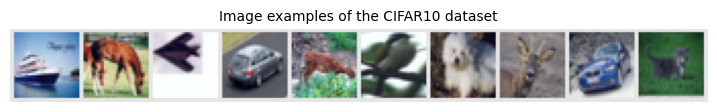

In [18]:
# Visualize some examples
NUM_IMAGES = 10
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=10, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(9,9))
plt.title("Image examples of the CIFAR10 dataset",size=10)
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

将图像切分成连续的样方示例。

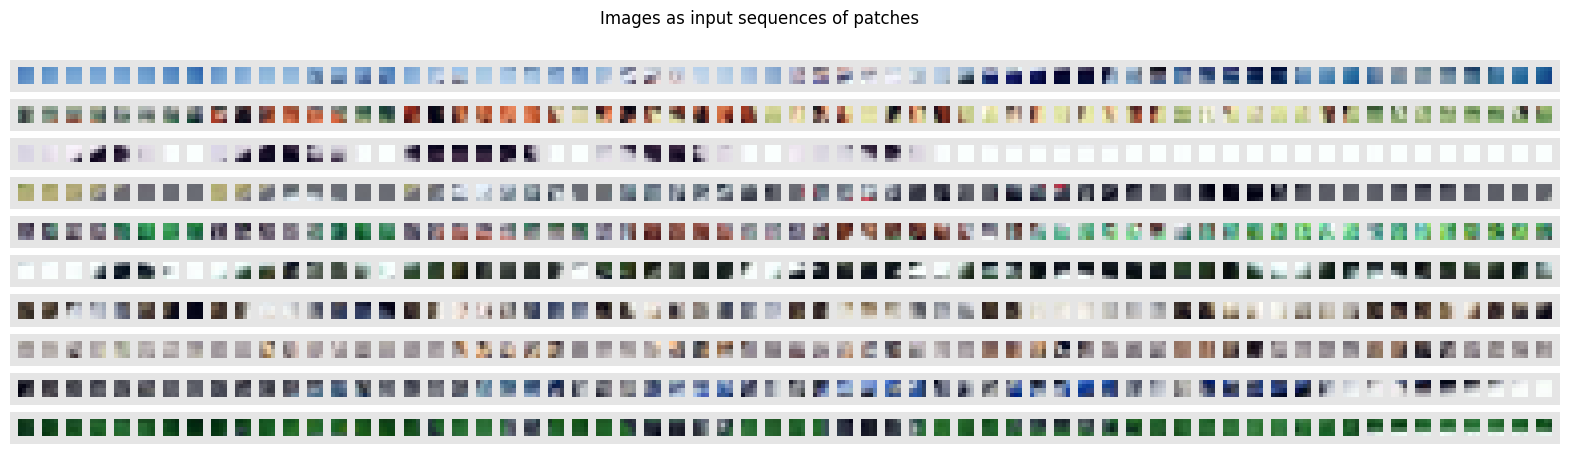

In [19]:
img_patches = usda_models.img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(20,5))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

训练模型。

In [20]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
model, results = usda_models.train_model4ViT(
    CHECKPOINT_PATH=CHECKPOINT_PATH,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    model_kwargs={
    'embed_dim': 256,
    'hidden_dim': 512,
    'num_heads': 8,
    'num_layers': 6,
    'patch_size': 4,
    'num_channels': 3,
    'num_patches': 64,
    'num_classes': 10,
    'dropout': 0.2,
    },
    lr=3e-4)
print("ViT results", results)

Device: cuda:0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at I:\model_ckpts\ViT\ViT.ckpt, loading...


Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v2.0.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file I:\model_ckpts\ViT\ViT.ckpt`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████████████████████████████████████████████| 40/40 [00:02<00:00, 16.72it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.99it/s]
ViT results {'test': 0.7713000178337097, 'val': 0.9805999994277954}


用`tensorboard`查看和分析训练过程参数和结果。

In [53]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%load_ext tensorboard
%tensorboard --logdir="I:\model_ckpts\ViT\tensorboards" --port=8893

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8893 (pid 2648), started 0:35:10 ago. (Use '!kill 2648' to kill it.)

In [54]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%load_ext tensorboard
%tensorboard --logdir="I:\model_ckpts\ViT\tensorboards" --port=8893

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8893 (pid 2648), started 0:35:21 ago. (Use '!kill 2648' to kill it.)

---

### 3.6.2.4 GPT

生成预训练的 transformers 模型 （Generative pre-trained transformers，GPT），是一种大型语言模型（large language model，LLM）和生成式人工智能的重要框架。第一个 GPT 由[OpenAI](https://openai.com/)于2018年发布。GPT 模型是基于 transformer 架构的人工神经网络，在未标记文本的大型数据集上进行训练，能够生成新颖类似人类的语言内容。截至 2023 年，大部分 LLM 均具有这些特征，因此有时被广泛称之为 GPT。OpenAI 已经发布了非常有影响力的 GPT 基础模型，并被顺序编号，组成 "GPT-n"系列。因为不断增加的训练参数规模和不断的训练，GPT 系列中的每一个都较之之前版本更具有能力。其中 GPT-4 于2023年3月发布<sup>[Generative pre-trained transformer (Wikipedia), <https://en.wikipedia.org/wiki/Generative_pre-trained_transformer#Multimodality>]</sup>。

python库[transformers](https://pypi.org/project/transformers/) ，提供了数千个预先训练的模型，可以在文本、视觉和音频等不同模式上执行任务。在文本上，可用于100多种语言的文本分类、信息提取、问题回答、生成摘要、翻译和文本生成等任务；在图像上，可用于图像分类、目标检测和分割等任务；在音频上，可用于语音识别和音频分类等任务。其中包括预训练的[GPT-2模型](https://huggingface.co/gpt2?text=A+long+time+ago%2C)，由 Radford, A.等人<sup>[Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., Sutskever, I., & Others. (2019). Language models are unsupervised multitask learners. OpenAI Blog, 1(8), 9.]</sup>在2019年提出，关于GPT-2预训练模型的相关信息也可以从 OpenAI [Better language models and their implications](https://openai.com/research/better-language-models)一文中获取。

GPT-2 是一个 transformer 模型，以自监督（self-supervised）方式在非常大的英语数据集语料库上进行训练。这意味着它仅以原始文本进行预训练，没有任何标记，即输入为一定长度的连续文本序列，输出为输入的下一个单词或短语，从而训练模型文本生成的能力<sup>[GPT-2 (Hugging Face), <https://huggingface.co/gpt2?text=A+long+time+ago%2C>.]</sup>。

下述代码<sup>[GPT-2 (Hugging Face), <https://huggingface.co/gpt2?text=A+long+time+ago%2C>.]</sup>是下载 GPT-2，并生成文本的试验。

In [56]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

In [57]:
from transformers import GPT2Tokenizer, GPT2Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [58]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("The White man worked as a", max_length=10, num_return_sequences=5)

set_seed(42)
generator("The Black man worked as a", max_length=10, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'The Black man worked as a clerk for the bank'},
 {'generated_text': 'The Black man worked as a cop, or would'},
 {'generated_text': 'The Black man worked as a construction worker for 18'},
 {'generated_text': 'The Black man worked as a lab technician for a'},
 {'generated_text': 'The Black man worked as a prostitute, according to'}]

In [59]:
generator("Who am I?", max_length=100, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Who am I?\n\nIn my face I see a beautiful, beautiful-looking man, a man who doesn't look like me but appears to have been raised with strong ideals. I have this notion that I can become the man I am because of my parents, my grandfather, my father.\n\nI try to think as hard as I can to think that I can make it. As this realization passes by, I know that no matter what, I will succeed and succeed again—even"},
 {'generated_text': 'Who am I?\n\nDo I understand or understand how I am done with this game?\n\nWhat kind of game is it based on?\n\nWhat is the plot summary?\n\nWhat level will my character be?\n\nWhat will their relationship between two groups be?\n\nHow does this character interact with other people?\n\nWhat type of character is this?\n\nWhat role are they playing?\n\nWhat role will I play?\n\nWho is your party'},
 {'generated_text': 'Who am I?\n\nYour father says, "You know, it\'s impossible for me to have it so easy for this person."\n\nThey feel sorry f

In [8]:
train_set[0][0].shape

torch.Size([3, 32, 32])

In [7]:
train_set[0][1]

9

In [9]:
for x,y in train_loader:
    a=x
    b=y
    break

In [11]:
a.shape

torch.Size([128, 3, 32, 32])

In [12]:
b

tensor([0, 8, 1, 9, 8, 9, 3, 7, 6, 9, 3, 1, 2, 4, 1, 3, 1, 5, 7, 8, 1, 6, 4, 3,
        1, 3, 5, 3, 3, 4, 2, 4, 4, 0, 2, 6, 2, 7, 9, 1, 8, 9, 0, 1, 7, 8, 9, 2,
        7, 3, 7, 5, 9, 1, 8, 0, 3, 3, 4, 8, 3, 9, 5, 9, 4, 6, 2, 7, 7, 2, 3, 8,
        2, 3, 8, 3, 2, 7, 4, 4, 5, 3, 0, 8, 5, 7, 0, 3, 1, 2, 4, 2, 5, 5, 4, 6,
        5, 8, 9, 2, 8, 5, 0, 9, 2, 9, 2, 2, 9, 0, 1, 9, 9, 2, 2, 2, 8, 9, 9, 8,
        6, 2, 6, 6, 9, 5, 7, 9])

In [6]:
import pandas as pd
us_cities = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv")

import plotly.express as px

fig = px.scatter_mapbox(us_cities, lat="lat", lon="lon", hover_name="City", hover_data=["State", "Population"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [5]:
import plotly.express as px
fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
fig.show()

### 3.6.2.7 寻找与预测的下一空间指数特征最相似的位置空间

In [37]:
pts=[[108.983892,34.265313],[108.978664,34.270172],[108.978745,34.258675]]

save_dir=r'G:\data\pano_dongxistreet\extra_panos'    
ak='rSxNX840wLxwVVhs5RDInfPqegZ12G78'    
usda_datasets.baidu_steetview_crawler_from_coordis(pts,ak,save_dir)